<a href="https://colab.research.google.com/github/bhar-gav/topic-specific-analysis-of-sentences/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
print(os.getcwd())
datasets="/content/drive/My Drive/Colab Notebooks/final-year/sentence-analysis/"
os.chdir(datasets)
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/My Drive/Colab Notebooks/final-year/sentence-analysis


In [ ]:
import pandas as pd

df1=pd.read_csv("datasets/un-general-debates.csv")
df2=pd.read_json("datasets/science-articles.json")
df3=pd.read_json("datasets/environment-articles.json")
df4=pd.read_json("datasets/sports-articles.json")

dfs=[df1,df2,df3,df4]
dataset_names=["UN Speeches","Science Articles","Environment Articles","Sports Articles"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i, df in enumerate (dfs,1):
  print(f"\n Dataset : {dataset_names[i-1]}")
  print(df.head())


 Dataset : UN Speeches
   session  year country                                               text
0       44  1989     MDV  ﻿It is indeed a pleasure for me and the member...
1       44  1989     FIN  ﻿\nMay I begin by congratulating you. Sir, on ...
2       44  1989     NER  ﻿\nMr. President, it is a particular pleasure ...
3       44  1989     URY  ﻿\nDuring the debate at the fortieth session o...
4       44  1989     ZWE  ﻿I should like at the outset to express my del...

 Dataset : Science Articles
                                                link  \
0  https://www.huffpost.com/entry/fuel-leak-ruins...   
1  https://www.huffpost.com/entry/nasa-artemis-mo...   
2  https://www.huffpost.com/entry/china-rocket-de...   
3  https://www.huffpost.com/entry/arthurs-stone-e...   
4  https://www.huffpost.com/entry/james-webb-spac...   

                                            headline category  \
0  Fuel Leak Ruins NASA's 2nd Shot At Launching N...  SCIENCE   
1  'Safety Is Always Fir

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install nltk gensim pyldavis


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from collections import Counter
import os


def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

def find_collocations(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_finder.apply_freq_filter(1)
    bigrams = bigram_finder.nbest(BigramAssocMeasures.chi_sq, 100)
    return ['_'.join(bigram) for bigram in bigrams]

output_dir = "processed_datasets"
os.makedirs(output_dir, exist_ok=True)

for df, name in zip(dfs, dataset_names):
    if 'text' in df.columns:
        text_column = 'text'
    elif 'article_text' in df.columns:
        text_column = 'article_text'
    else:
        print(f"Warning: Neither 'text' nor 'article_text' column found in {name}. Skipping...")
        continue

    df['tokens'] = df[text_column].fillna('').astype(str).apply(preprocess)
    df = df[df['tokens'].map(len) > 0]

    all_tokens = [token for sublist in df['tokens'] for token in sublist]
    token_counts = Counter(all_tokens)
    infrequent_tokens = {token for token, count in token_counts.items() if count < 10}

    df['tokens'] = df['tokens'].apply(lambda x: [token for token in x if token not in infrequent_tokens])
    df['collocations'] = df['tokens'].apply(find_collocations)
    df['final_tokens'] = df.apply(lambda x: x['tokens'] + x['collocations'], axis=1)

    # Store original DataFrame with the new 'final_tokens' column
    output_file = os.path.join(output_dir, f"{name.replace(' ', '_')}_processed.json")
    df[['final_tokens'] + [col for col in df.columns if col != 'final_tokens']].to_json(output_file, orient='records', lines=True)
    print(f"Processed DataFrame for {name} saved to {output_file}.")

print("All datasets processed and saved.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


NameError: name 'dfs' is not defined

Step 2

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import os

df1 = pd.read_json("processed_datasets/UN_Speeches_processed.json", orient='records', lines=True)
df2 = pd.read_json("processed_datasets/Science_Articles_processed.json", orient='records', lines=True)
df3 = pd.read_json("processed_datasets/Environment_Articles_processed.json", orient='records', lines=True)
df4 = pd.read_json("processed_datasets/Sports_Articles_processed.json", orient='records', lines=True)

dfs = [df1, df2, df3, df4]
dataset_names = ["UN Speeches", "Science Articles", "Environment Articles", "Sports Articles"]

if 'final_tokens' not in df1.columns:
    raise ValueError("The column 'final_tokens' is missing from the first DataFrame.")

final_tokens = df1['final_tokens'].tolist()

dictionary = corpora.Dictionary(final_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in final_tokens]

num_topics = 8
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

top_n_words = 20
topics = lda_model.show_topics(num_topics=num_topics, num_words=top_n_words, formatted=False)

topic_words = {f'Topic {i+1}': [word for word, _ in words] for i, (_, words) in enumerate(topics)}
topic_words_df = pd.DataFrame(topic_words)

print("Table 1. Top 20 Topic Words Identified By Non-Sequential Unseeded LDA:")
print(topic_words_df)

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization_step1.html')


Table 1. Top 20 Topic Words Identified By Non-Sequential Unseeded LDA:
          Topic 1        Topic 2        Topic 3        Topic 4        Topic 5  \
0   international    development  international        nations         israel   
1           world         united      countries         united           arab   
2         nations  international          peace  international          peace   
3          united        nations       economic          world       security   
4       countries       security         africa           must         people   
5            must          peace        nations       security  international   
6        security      countries    development          human    palestinian   
7           peace           also          world            new           iraq   
8     development         states      community         rights         united   
9          people          world         united          peace        council   
10       economic         global      

In [ ]:
import pandas as pd
import nltk
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

# Load datasets
df1 = pd.read_json("processed_datasets/UN_Speeches_processed.json", orient='records', lines=True)
df2 = pd.read_json("processed_datasets/Science_Articles_processed.json", orient='records', lines=True)
df3 = pd.read_json("processed_datasets/Environment_Articles_processed.json", orient='records', lines=True)
df4 = pd.read_json("processed_datasets/Sports_Articles_processed.json", orient='records', lines=True)

# Ensure 'final_tokens' is in the DataFrame
if 'final_tokens' not in df1.columns:
    raise ValueError("The column 'final_tokens' is missing from the first DataFrame.")

# Prepare the tokens
final_tokens = df1['final_tokens'].tolist()

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(final_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in final_tokens]

# Fit the LDA model
num_topics = 8
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Extract the top words for each topic
top_n_words = 100  # Extract top 100 words
topics = lda_model.show_topics(num_topics=num_topics, num_words=top_n_words, formatted=False)

# Gather top words
top_words = [word for _, words in topics for word, _ in words]

# Define existing seed words
existing_seed_words = {
    "Greeting": [
        "thank", "thanks", "congratulate", "congratulations", "sir", "express",
        "great", "greater", "mr", "wish", "wishes", "hope", "contribution",
        "contribute", "anniversary", "welcome", "welcomes", "honor", "appreciate",
        "acknowledge", "pleasure", "delighted", "gratitude", "respect",
        "salutations", "regard", "cordial", "kind", "invite", "invitation",
        "greetings", "best wishes", "respectfully", "sincerely", "appreciation",
        "compliment", "express my gratitude", "honorable"
    ],
    "UN": [
        "united nations", "security council", "general assembly", "organization",
        "organizations", "reform", "reforms", "secretary-general", "resolution",
        "resolutions", "charter", "session", "conference", "multilateral",
        "diplomacy", "global governance", "peacekeeping", "international law",
        "mandate", "cooperation", "members", "affairs", "protocol", "agenda",
        "declaration", "humanitarian", "summit", "global partnership", "consensus",
        "participation", "collaboration", "international community"
    ],
    "Security": [
        "security", "security council", "victims", "peace", "peaceful",
        "peacekeeping", "peace-keeping", "terrorism", "terrorist", "weapons",
        "nuclear", "conflicts", "conflict", "war", "wars", "disarmament",
        "threat", "threats", "crisis", "solutions", "solution", "settlement",
        "forces", "force", "destruction", "military", "violence", "armed",
        "arms", "fight", "defense", "safety", "protection", "stability",
        "strategic", "deterrence", "insurgency", "counterterrorism", "hostilities",
        "safeguard", "militarization", "peacekeeping operations"
    ],
    "Human Rights": [
        "human rights", "dignity", "protection", "protect", "citizens",
        "education", "humanitarian", "children", "women", "refugees", "community",
        "people", "respect", "responsibility", "food", "health",
        "equality", "justice", "freedom", "liberty", "discrimination",
        "empowerment", "advocacy", "treatment", "integration", "rights",
        "civil rights", "social justice", "fairness", "inclusion", "access",
        "non-discrimination", "advancement", "tolerance", "socioeconomic rights",
        "fundamental freedoms", "safety", "dignified"
    ],
    "Democracy": [
        "democracy", "democratic", "representative", "election", "elections",
        "leadership", "president", "institutions", "government", "law",
        "republic", "free", "freedom", "legal", "participation", "accountability",
        "transparency", "voter", "rights", "civic engagement", "pluralism",
        "public opinion", "political", "civil society", "suffrage", "majority",
        "minority", "governance", "liberal democracy", "vote", "referendum",
        "representation", "candidates", "political parties", "activism"
    ],
    "Development": [
        "development", "developing", "developed", "developments", "market",
        "markets", "investment", "economic", "economy", "economies",
        "climate change", "assistance", "sustainable", "poverty", "trade",
        "growth", "social", "environment", "environmental", "prosperity",
        "progress", "financial", "cooperation", "infrastructure", "innovation",
        "globalization", "capacity building", "resources", "partnerships",
        "investment", "aid", "sustainability", "economic growth", "social development",
        "equity", "benefits", "collaboration", "support", "strategies",
        "international aid", "community development", "integration"
    ]
}

# Match top words to existing seed words
matched_seed_words = {topic: [] for topic in existing_seed_words.keys()}

for topic, seeds in existing_seed_words.items():
    for word in seeds:
        if word in top_words:
            matched_seed_words[topic].append(word)

# Convert matched seed words to DataFrame for easier viewing
matched_seed_words_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in matched_seed_words.items()]))

# Display results
print("Table 1. Top 100 Topic Words Identified By Non-Sequential Unseeded LDA:")
topic_words = {f'Topic {i+1}': [word for word, _ in words] for i, (_, words) in enumerate(topics)}
topic_words_df = pd.DataFrame(topic_words)
print(topic_words_df)

print("\nTable 2. Seed Words Selected From the Top 100 Topic Words of A Non-Sequential Unseeded LDA Model:")
print(matched_seed_words_df[:20])

# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization_step2.html')


Table 1. Top 100 Topic Words Identified By Non-Sequential Unseeded LDA:
          Topic 1        Topic 2        Topic 3        Topic 4        Topic 5  \
0          united      countries          world  international        nations   
1          states  international        nations          peace         united   
2   international        nations          peace       security  international   
3       countries          world         united           arab    development   
4         nations         africa  international         israel          world   
..            ...            ...            ...            ...            ...   
95         middle           view        central          libya          first   
96           year       peaceful          basis     government        members   
97           made           take        justice        morocco      including   
98          means      president      therefore  establishment        nuclear   
99   organization        however     

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training LDA model with r=2, μ=0.02, σ=0
Coherence Score: 0.3075
Training LDA model with r=2, μ=0.02, σ=0.5
Coherence Score: 0.3415
Training LDA model with r=2, μ=0.04, σ=0
Coherence Score: 0.3058
Training LDA model with r=2, μ=0.04, σ=0.5
Coherence Score: 0.3051

Best Coherence Score: 0.3415 with parameters: {'residual_topics': 2, 'seed_weight': 0.02, 'preceding_influence': 0.5}


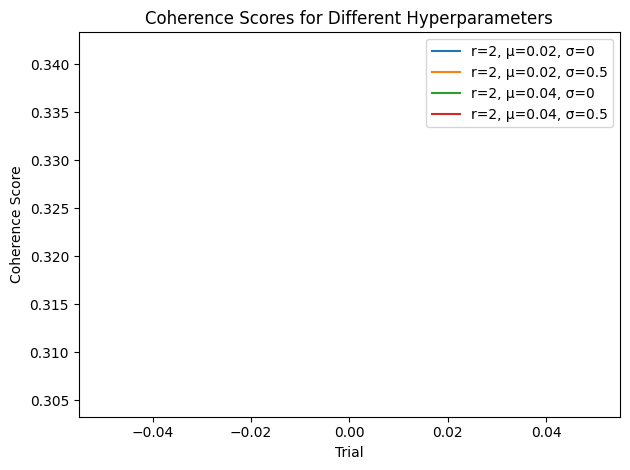

NameError: name 'top_words' is not defined

In [5]:
import pandas as pd
import nltk
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from collections import defaultdict

# Set of stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Load datasets
df1 = pd.read_json("processed_datasets/UN_Speeches_processed.json", orient='records', lines=True)
df2 = pd.read_json("processed_datasets/Science_Articles_processed.json", orient='records', lines=True)
df3 = pd.read_json("processed_datasets/Environment_Articles_processed.json", orient='records', lines=True)
df4 = pd.read_json("processed_datasets/Sports_Articles_processed.json", orient='records', lines=True)

# Ensure 'final_tokens' is in the DataFrame
if 'final_tokens' not in df1.columns:
    raise ValueError("The column 'final_tokens' is missing from the first DataFrame.")

# Prepare the tokens
final_tokens = df1['final_tokens'].tolist()

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(final_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in final_tokens]

# Fit the LDA model
num_topics = 8
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Extract the top words for each topic
top_n_words = 100  # Extract top 100 words
topics = lda_model.show_topics(num_topics=num_topics, num_words=top_n_words, formatted=False)

# Gather top words
top_words = [word for _, words in topics for word, _ in words]

# Define hyperparameters to optimize
residual_topics = [2]  # Values for r
seed_weights = [0.02, 0.04]  # Values for μ
preceding_sentence_influence = [0, 0.5]  # Values for σ

best_model = None
best_coherence = float('-inf')
best_params = {}

coherence_results = defaultdict(list)

# Evaluate combinations of hyperparameters
for r in residual_topics:
    for mu in seed_weights:
        for sigma in preceding_sentence_influence:
            print(f"Training LDA model with r={r}, μ={mu}, σ={sigma}")
            lda_model = LdaModel(corpus, num_topics=8, id2word=dictionary, passes=15)
            coherence_model = CoherenceModel(model=lda_model, texts=final_tokens, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            print(f"Coherence Score: {coherence_score:.4f}")

            # Store the results for plotting later
            coherence_results[(r, mu, sigma)].append(coherence_score)

            # Check if this is the best model
            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_params = {'residual_topics': r, 'seed_weight': mu, 'preceding_influence': sigma}
                best_model = lda_model
            del lda_model

# Output best parameters and coherence score
print(f"\nBest Coherence Score: {best_coherence:.4f} with parameters: {best_params}")

# Save the best model
best_model.save("best_lda_model.model")

# Visualization of coherence scores
fig, ax = plt.subplots()
for (r, mu, sigma), scores in coherence_results.items():
    ax.plot(scores, label=f'r={r}, μ={mu}, σ={sigma}')

ax.set_title("Coherence Scores for Different Hyperparameters")
ax.set_xlabel("Trial")
ax.set_ylabel("Coherence Score")
ax.legend()
plt.tight_layout()
plt.savefig('coherence_scores_comparison.png')  # Save the plot
plt.show()

# Prepare and save the visualization of the best model
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization_best_model.html')

# Match top words to existing seed words for analysis
top_n_words = 100
topics = best_model.show_topics(num_topics=8, num_words=top_n_words, formatted=False)


# Define existing seed words
existing_seed_words = {
    "Greeting": [
        "thank", "thanks", "congratulate", "congratulations", "sir", "express",
        "great", "greater", "mr", "wish", "wishes", "hope", "contribution",
        "contribute", "anniversary", "welcome", "welcomes", "honor", "appreciate",
        "acknowledge", "pleasure", "delighted", "gratitude", "respect",
        "salutations", "regard", "cordial", "kind", "invite", "invitation",
        "greetings", "best wishes", "respectfully", "sincerely", "appreciation",
        "compliment", "express my gratitude", "honorable"
    ],
    "UN": [
        "united nations", "security council", "general assembly", "organization",
        "organizations", "reform", "reforms", "secretary-general", "resolution",
        "resolutions", "charter", "session", "conference", "multilateral",
        "diplomacy", "global governance", "peacekeeping", "international law",
        "mandate", "cooperation", "members", "affairs", "protocol", "agenda",
        "declaration", "humanitarian", "summit", "global partnership", "consensus",
        "participation", "collaboration", "international community"
    ],
    "Security": [
        "security", "security council", "victims", "peace", "peaceful",
        "peacekeeping", "peace-keeping", "terrorism", "terrorist", "weapons",
        "nuclear", "conflicts", "conflict", "war", "wars", "disarmament",
        "threat", "threats", "crisis", "solutions", "solution", "settlement",
        "forces", "force", "destruction", "military", "violence", "armed",
        "arms", "fight", "defense", "safety", "protection", "stability",
        "strategic", "deterrence", "insurgency", "counterterrorism", "hostilities",
        "safeguard", "militarization", "peacekeeping operations"
    ],
    "Human Rights": [
        "human rights", "dignity", "protection", "protect", "citizens",
        "education", "humanitarian", "children", "women", "refugees", "community",
        "people", "respect", "responsibility", "food", "health",
        "equality", "justice", "freedom", "liberty", "discrimination",
        "empowerment", "advocacy", "treatment", "integration", "rights",
        "civil rights", "social justice", "fairness", "inclusion", "access",
        "non-discrimination", "advancement", "tolerance", "socioeconomic rights",
        "fundamental freedoms", "safety", "dignified"
    ],
    "Democracy": [
        "democracy", "democratic", "representative", "election", "elections",
        "leadership", "president", "institutions", "government", "law",
        "republic", "free", "freedom", "legal", "participation", "accountability",
        "transparency", "voter", "rights", "civic engagement", "pluralism",
        "public opinion", "political", "civil society", "suffrage", "majority",
        "minority", "governance", "liberal democracy", "vote", "referendum",
        "representation", "candidates", "political parties", "activism"
    ],
    "Development": [
        "development", "developing", "developed", "developments", "market",
        "markets", "investment", "economic", "economy", "economies",
        "climate change", "assistance", "sustainable", "poverty", "trade",
        "growth", "social", "environment", "environmental", "prosperity",
        "progress", "financial", "cooperation", "infrastructure", "innovation",
        "globalization", "capacity building", "resources", "partnerships",
        "investment", "aid", "sustainability", "economic growth", "social development",
        "equity", "benefits", "collaboration", "support", "strategies",
        "international aid", "community development", "integration"
    ]
}

# Match top words to existing seed words
matched_seed_words = {topic: [] for topic in existing_seed_words.keys()}

for topic, seeds in existing_seed_words.items():
    for word in seeds:
        if word in top_words:
            matched_seed_words[topic].append(word)

# Convert matched seed words to DataFrame for easier viewing
matched_seed_words_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in matched_seed_words.items()]))

# Display results
print("\nTable 1. Top 100 Topic Words Identified By Non-Sequential Unseeded LDA:")
topic_words = {f'Topic {i+1}': [word for word, _ in words] for i, (_, words) in enumerate(topics)}
topic_words_df = pd.DataFrame(topic_words)
print(topic_words_df)

print("\nTable 2. Seed Words Selected From the Top 100 Topic Words of A Non-Sequential Unseeded LDA Model:")
print(matched_seed_words_df)


In [ ]:
import pandas as pd
import nltk
from gensim import corpora
from gensim.models import LdaModel

# Load the saved LDA model
lda_model = LdaModel.load("best_lda_model.model")

# Load the dictionary used for creating the model
dictionary = corpora.Dictionary.load("best_lda_model.model.id2word")  # Adjust path if necessary

# Preprocess function (similar to what was used before)
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha()]

# Example sentences to classify
sentences_to_classify = [
    "We must strengthen international cooperation to promote peace.",
    "Human rights are essential for the dignity of all individuals.",
    "Economic development is critical for sustainable growth.",
    "The United Nations plays a vital role in global governance.",
    "Security measures are necessary to combat terrorism."
]

# Preprocess the sentences
processed_sentences = [preprocess(sentence) for sentence in sentences_to_classify]

# Create a bag-of-words representation for the processed sentences
corpus = [dictionary.doc2bow(tokens) for tokens in processed_sentences]

# Infer topics for each sentence
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Assign the most probable topic to each sentence
topic_assignments = []
for distribution in topic_distributions:
    if distribution:
        # Sort by probability and take the highest
        topic_assignments.append(max(distribution, key=lambda x: x[1])[0])
    else:
        topic_assignments.append(None)  # No topic assigned

# Combine sentences with their assigned topics
classified_results = pd.DataFrame({
    "Sentence": sentences_to_classify,
    "Assigned Topic": topic_assignments
})

# Display the results
print(classified_results)


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

# Load your DataFrame
df = pd.DataFrame()  # Create an empty DataFrame
df['speech'] = df1['text'].fillna('').astype(str)  # Ensure 'text' column exists

# Set of stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    return tokens

# Apply preprocessing to the 'speech' column
df['tokens'] = df['speech'].apply(preprocess)
df = df[df['tokens'].map(len) > 0]  # Keep only rows with tokens

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Fit the LDA model
num_topics = 5  # Adjust based on your dataset
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics and their keywords
print("Topics and Keywords:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Get the topics and their keywords for easier visualization
topics = lda_model.show_topics(formatted=False)
topics_keywords = {idx: [word for word, _ in words] for idx, words in topics}

# Print the keywords for each topic
print("\nKeywords for each topic:")
for topic, keywords in topics_keywords.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Topics and Keywords:
Topic 0: 0.012*"countries" + 0.012*"international" + 0.011*"united" + 0.009*"nations" + 0.009*"people" + 0.009*"world" + 0.008*"states" + 0.008*"peace" + 0.006*"economic" + 0.005*"africa"
Topic 1: 0.014*"nations" + 0.014*"development" + 0.012*"united" + 0.009*"countries" + 0.009*"international" + 0.007*"world" + 0.006*"global" + 0.006*"must" + 0.005*"economic" + 0.005*"also"
Topic 2: 0.012*"international" + 0.010*"countries" + 0.008*"world" + 0.007*"nations" + 0.007*"peace" + 0.007*"economic" + 0.007*"development" + 0.006*"country" + 0.006*"must" + 0.005*"united"
Topic 3: 0.018*"united" + 0.018*"nations" + 0.015*"international" + 0.011*"security" + 0.008*"peace" + 0.007*"council" + 0.006*"world" + 0.006*"development" + 0.006*"states" + 0.006*"also"
Topic 4: 0.012*"world" + 0.010*"people" + 0.008*"nations" + 0.008*"united" + 0.008*"us" + 0.007*"must" + 0.007*"one" + 0.005*"peace" + 0.005*"would" + 0.005*"war"

Keywords for each topic:
Topic 0: countries, internation

**Summary of Topic Names   
Topic 0: International Cooperation for Peace
Topic 1: Global Development Strategies
Topic 2: Peace and Economic Development
Topic 3: Security and International Governance
Topic 4: Unity for Peace and Conflict Resolution**

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


df = pd.DataFrame()
df['speech'] = df1['text'].fillna('').astype(str)  # Ensure 'text' column exists

# Set of stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    return tokens

# Apply preprocessing to the 'speech' column
df['tokens'] = df['speech'].apply(preprocess)
df = df[df['tokens'].map(len) > 0]  # Keep only rows with tokens

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Fit the LDA model
num_topics = 5  # Adjust based on your dataset
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics and their keywords
print("Topics and Keywords:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Get the topics and their keywords for easier visualization
topics = lda_model.show_topics(formatted=False)
topics_keywords = {idx: [word for word, _ in words] for idx, words in topics}

# Print the keywords for each topic
print("\nKeywords for each topic:")
for topic, keywords in topics_keywords.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# Evaluate the model using coherence score
coherence_model = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nCoherence Score: {coherence_score:.4f}")

# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# If you want to save the visualization to an HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topics and Keywords:
Topic 0: 0.023*"people" + 0.016*"country" + 0.015*"state" + 0.011*"united" + 0.009*"international" + 0.008*"republic" + 0.008*"world" + 0.008*"peace" + 0.007*"nation" + 0.006*"government"
Topic 1: 0.018*"international" + 0.012*"united" + 0.012*"security" + 0.011*"nation" + 0.011*"peace" + 0.009*"state" + 0.008*"country" + 0.007*"effort" + 0.006*"world" + 0.006*"council"
Topic 2: 0.016*"development" + 0.015*"country" + 0.013*"nation" + 0.012*"international" + 0.011*"united" + 0.007*"world" + 0.007*"state" + 0.006*"economic" + 0.006*"global" + 0.005*"support"
Topic 3: 0.018*"nation" + 0.016*"united" + 0.009*"must" + 0.009*"world" + 0.007*"human" + 0.006*"security" + 0.006*"right" + 0.006*"u" + 0.006*"year" + 0.006*"peace"
Topic 4: 0.014*"country" + 0.011*"nation" + 0.010*"world" + 0.010*"international" + 0.007*"united" + 0.007*"economic" + 0.006*"problem" + 0.006*"africa" + 0.006*"people" + 0.005*"peace"

Keywords for each topic:
Topic 0: people, country, state, unit

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import os
from sklearn.model_selection import ParameterGrid


# Create a new DataFrame
df = pd.DataFrame()
df['speech'] = df1['text'].fillna('').astype(str)  # Ensure 'text' column exists

# Set of stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

# Preprocessing function with unigrams, bigrams, and trigrams
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    # Create bigrams and trigrams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    # Combine unigrams, bigrams, and trigrams
    return tokens + ['_'.join(bigram) for bigram in bigrams] + ['_'.join(trigram) for trigram in trigrams]

# Apply preprocessing to the 'speech' column
df['tokens'] = df['speech'].apply(preprocess)
df = df[df['tokens'].map(len) > 0]  # Keep only rows with tokens

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Define hyperparameter grid including combinations of n-grams
param_grid = {
    'num_topics': [5],
    'passes': [10, 20],
    'alpha': ['auto', 0.01, 0.1],
    'beta': ['auto', 0.01, 0.1]
}

# Create a directory to save visualizations
output_dir = "lda_visualizations"
os.makedirs(output_dir, exist_ok=True)

# Grid search over hyperparameters
best_coherence = 0
best_params = {}

for params in ParameterGrid(param_grid):
    print(f"Training LDA model with parameters: {params}")

    # Fit the LDA model
    lda_model = LdaModel(corpus, num_topics=params['num_topics'], id2word=dictionary,
                         passes=params['passes'], alpha=params['alpha'], beta=params['beta'])

    # Evaluate the model using coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score: {coherence_score:.4f}")

    # Check if this is the best model
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_params = params

    # Visualize the topics
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

    # Save the visualization to an HTML file
    html_file = f"{output_dir}/lda_visualization_topics_{params['num_topics']}_passes_{params['passes']}_alpha_{params['alpha']}_beta_{params['beta']}.html"
    pyLDAvis.save_html(vis, html_file)
    print(f"Saved visualization to: {html_file}")

# Output best parameters and coherence score
print(f"\nBest Coherence Score: {best_coherence:.4f} with parameters: {best_params}")

# Optionally, you can fit the best model again for final visualization
best_lda_model = LdaModel(corpus, num_topics=best_params['num_topics'], id2word=dictionary,
                           passes=best_params['passes'], alpha=best_params['alpha'], beta=best_params['beta'])

# Final visualization of the best model (Optional)
final_vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, dictionary)
pyLDAvis.save_html(final_vis, f"{output_dir}/lda_visualization_best_model.html")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training LDA model with parameters: {'alpha': 'auto', 'beta': 'auto', 'num_topics': 5, 'passes': 10}


TypeError: LdaModel.__init__() got an unexpected keyword argument 'beta'

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
import os

# Create a new DataFrame
df = pd.DataFrame()
df['speech'] = df1['text'].fillna('').astype(str)  # Ensure 'text' column exists


stop_words = set(stopwords.words('english'))

# Preprocessing function with unigrams, bigrams, and trigrams
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove punctuation and stopwords
    # Create bigrams and trigrams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    # Combine unigrams, bigrams, and trigrams
    return tokens + ['_'.join(bigram) for bigram in bigrams] + ['_'.join(trigram) for trigram in trigrams]

# Apply preprocessing to the 'speech' column
df['tokens'] = df['speech'].apply(preprocess)
df = df[df['tokens'].map(len) > 0]  # Keep only rows with tokens

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Function to compute coherence scores for different number of topics
def find_optimal_topics(corpus, dictionary, min_topics=3, max_topics=60):
    coherence_scores = []
    for num_topics in range(min_topics, max_topics + 1):
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        coherence_model = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

    return coherence_scores

# Find optimal number of topics
coherence_results = find_optimal_topics(corpus, dictionary)

# Plotting coherence scores
plt.figure(figsize=(10, 5))
plt.plot([num_topics for num_topics, _ in coherence_results], [score for _, score in coherence_results])
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Different Number of Topics')
plt.grid()
plt.show()

# Choosing the optimal number of topics based on the results
optimal_num_topics = max(coherence_results, key=lambda x: x[1])[0]

# Fitting the final LDA model with the optimal number of topics
lda_model = LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=15)

# Extract seed words from the unseeded LDA model
topics = lda_model.show_topics(formatted=False)
seed_words = {idx: [word for word, _ in words] for idx, words in topics}

# Print the keywords for each topic
print("\nKeywords for each topic:")
for topic, keywords in seed_words.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# Evaluation of Seeded Sequential LDA
# Define hyperparameters to test
residual_topics_options = [0, 1, 2, 5, 10, 15]
seed_weight_options = [0.01, 0.02, 0.03, 0.04, 0.05]
preceding_sentence_influence = [0, 0.5]

best_coherence = 0
best_params = {}

# Grid search for hyperparameters
for r in residual_topics_options:
    for mu in seed_weight_options:
        for sigma in preceding_sentence_influence:
            print(f"\nTesting with residual topics: {r}, seed weight: {mu}, influence: {sigma}")
            # Fitting the Seeded Sequential LDA model
            # Placeholder for model fitting with seeded parameters
            # This is where you would implement your actual model fitting code
            # For example:
            # lda_model = fit_seeded_sequential_lda(corpus, dictionary, seed_words, r, mu, sigma)
            # Then compute coherence score
            # coherence_model = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
            # coherence_score = coherence_model.get_coherence()
            # print(f"Coherence Score: {coherence_score:.4f}")

            # Check if this is the best model (pseudo-code)
            # if coherence_score > best_coherence:
            #     best_coherence = coherence_score
            #     best_params = {'residual_topics': r, 'seed_weight': mu, 'preceding_influence': sigma}

# Output best parameters and coherence score
# print(f"\nBest Coherence Score: {best_coherence:.4f} with parameters: {best_params}")

# Save final visualization
final_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(final_vis, 'final_lda_visualization.html')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
